## Bisimulation

A bisimulation relation is a way to group states in an MDP such that states in the same group (equivalence class) behave similarly in terms of both rewards and transitions.

Conditions for Bisimulation

1. **Reward Equivalence**: For any action $a$ in the set of actions $A$, the reward received in state $s$ must be the same as the reward received in state $t$
2. **Transition Probability Equivalence**: For any action a in 
𝑎
a in the set of actions 
𝐴
A, and for any equivalence class 
𝑐
c of states, the probability of moving to any state in 
𝑐
c from state 
𝑠
s must be the same as the probability of moving to any state in 
𝑐
c from state 
𝑡
t.

Calculate all the possible subsets (groups) among all the states and then check both conditions is really expensive. In fact, if I have n states, I will have a complexity of O(2^n) to calculate all the possible combination of subsets (groups).

A better approach is first to group by the reward equivalence condition, and then based on those groups hand made different groups and check if the groups hold the second condition of transition equivalence. This was my approach.

In [63]:
import numpy as np
from collections import defaultdict

ACTION_SPACE = ['up', 'down', 'left', 'right']
ACTION2IDX = {'u': 0, 'd': 1, 'l': 2, 'r': 3}
REWARD_FUNC = {'G': 10, '.': -1, 'T': 1} # goal, empty, terminal


def read_grid_world(file_path):
    with open(file_path, 'r') as file:
        grid = [line.split() for line in file]
    return np.array(grid)

def get_neighbors(grid, row, col):
    neighbors = {
        'up': (row - 1, col),
        'down': (row + 1, col),
        'left': (row, col - 1),
        'right': (row, col + 1)
    }
    valid_neighbors = {}
    for action, (r, c) in neighbors.items():
        if 0 <= r < grid.shape[0] and 0 <= c < grid.shape[1] and grid[r, c] != 'x':
            valid_neighbors[action] = (r, c)
        else:
            valid_neighbors[action] = (row, col)  # stay in the same state if out of bounds or wall
    return valid_neighbors

def calculate_rewards_and_transitions(grid):
    states = {}
    rewards = {}
    transitions = {}
    for row in range(grid.shape[0]):
        for col in range(grid.shape[1]):
            state = (row, col)
            if grid[row, col] == 'G':
                # NOTE: Terminal state in the goal has a reward of 0
                rewards[state] = {action: REWARD_FUNC['T'] for action in ACTION_SPACE}
                transitions[state] = {action: {state: 1.0} for action in ACTION_SPACE}
            elif grid[row, col] == '.':
                rewards[state] = {}
                transitions[state] = {}
                neighbors = get_neighbors(grid, row, col)
                for action, (r, c) in neighbors.items():
                    if grid[r, c] == 'G':
                        rewards[state][action] = REWARD_FUNC['G']
                    else:
                        rewards[state][action] = REWARD_FUNC['.']
                    transitions[state][action] = {(r, c): 1.0}
    return rewards, transitions

def print_rewards_and_transitions(rewards, transitions):
    for state, actions in rewards.items():
        print(f"State {state}:")
        for action, reward in actions.items():
            print(f"  Action {action}: Reward = {reward}, Transition = {transitions[state][action]}")

def print_one_hot_rewards(rewards):
    for state, actions in rewards.items():
        one_hot_rewards = list(actions.values())
        print("State", state, one_hot_rewards)

def group_by_reward_equivalente(rewards, policy = None):
    groups = defaultdict(list)
    for state, actions in rewards.items():

        # NOTE: on-policy bisimulation: reward equivalence groups
        if policy is not None:

            policy_action = policy[state]
            if policy_action == ' ': # terminal state
                policy_action = 'r' # set any action because leaves to zero reward

            policy_action = ACTION2IDX[policy_action]
            reward = list(actions.values())[policy_action]
            groups[reward].append(state)

        # NOTE: bisimulation: reward equivalence groups (group by one_hot_reward)
        else: 
            one_hot_reward = tuple(actions.values())
            groups[one_hot_reward].append(state)
    return groups

def replace_groups_keys(groups):
    result = {}
    for i, (_, states) in enumerate(groups.items()):
        result[f"c{i + 1}"] = states
    
    return result
        
def state_tuple_to_idx(state, grid):
    return state[0] * grid.shape[1] + state[1]

def plot_transition_equivalences(groups, probs_per_group_state_group, plot_format = 1):
    # Plot one hot per group
    print("Checking probs one hots by groups: ")
    for i, (_, states) in enumerate(groups.items()):
        print(f"c{i + 1}: ")
        
        assertion_list = []
        for state in states:
            state_idx = state_tuple_to_idx(state, grid)

            tmp_list = []
            for j, (_, _) in enumerate(groups.items()):
                
                if plot_format == 0:
                    print(f"State {state} to group c{j + 1}: ", probs_per_group_state_group[i,state_idx,j,:])
                tmp_list.append(list(probs_per_group_state_group[i,state_idx,j,:]))
            
            if plot_format == 1:
                print("State {} to all groups: ".format(state), tmp_list)

            assertion_list.append(tmp_list)
        
        # Check if all the list in assertion_list are the same and print a message if not
        for i in range(len(assertion_list) - 1):
            if assertion_list[i] != assertion_list[i + 1]:
                print(f"The transition probabilities are not the same for all the states in the group c{i + 1}")
                break


def check_transition_equivalence(groups, transitions, grid, policy = None, plot_format = 1):

    grid = np.array(grid)

    n_states = grid.shape[0] * grid.shape[1]

    if policy is not None:
        probs_per_group_state_group = np.zeros((len(groups), n_states, len(groups), 1))
    else:
        probs_per_group_state_group = np.zeros((len(groups), n_states, len(groups), 4))

    # Loop towards all the groups c1, c2, ..
    for i, (_, states) in enumerate(groups.items()):

        # Loop towards all the states in the group c_i
        for state in states:
            
            # Loop towards all the groups c1, c2, ..
            for j, (_, next_states) in enumerate(groups.items()):
                
                # On-policy bisimulation: I only need to consider the action that the policy takes
                if policy is not None:
                    
                    policy_action = policy[state]
                    if policy_action == ' ': # terminal state
                        policy_action = 'r' # set any action because leaves to zero reward

                    action = ACTION_SPACE[ACTION2IDX[policy_action]]
                        
                    tmp_prob = 0
                    for next_state in next_states:
                        # Check if it is possible to transtion from state to next_state using action
                        # if not return 0
                        tmp_prob += int(transitions[state][action].get(next_state, 0))

                    state_idx = state_tuple_to_idx(state, grid)
                    probs_per_group_state_group[i, state_idx, j, 0] = tmp_prob

                else:
                    
                    # Bisimulation: I need to consider all the actions
                    for k, action in enumerate(['up', 'down', 'left', 'right']):
                                                
                        # Loop towards all the states in the group c_j
                        tmp_prob = 0
                        for next_state in next_states:
                            # Check if it is possible to transtion from state to next_state using action
                            # if not return 0
                            tmp_prob += int(transitions[state][action].get(next_state, 0))


                        state_idx = state_tuple_to_idx(state, grid)
                        probs_per_group_state_group[i, state_idx, j, k] = tmp_prob
    
    plot_transition_equivalences(groups, probs_per_group_state_group, plot_format)

    return probs_per_group_state_group


file_path = 'custom_envs/grid_envs/grid_world.txt'
grid = read_grid_world(file_path)
print(grid)

rewards, transitions = calculate_rewards_and_transitions(grid)
rewards

[['.' '.' 'G']
 ['.' '.' '.']
 ['x' 'x' 'x']
 ['.' '.' 'G']
 ['.' '.' '.']]


{(0, 0): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
 (0, 1): {'up': -1, 'down': -1, 'left': -1, 'right': 10},
 (0, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 (1, 0): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
 (1, 1): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
 (1, 2): {'up': 10, 'down': -1, 'left': -1, 'right': -1},
 (3, 0): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
 (3, 1): {'up': -1, 'down': -1, 'left': -1, 'right': 10},
 (3, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 (4, 0): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
 (4, 1): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
 (4, 2): {'up': 10, 'down': -1, 'left': -1, 'right': -1}}

In [64]:
transitions

{(0, 0): {'up': {(0, 0): 1.0},
  'down': {(1, 0): 1.0},
  'left': {(0, 0): 1.0},
  'right': {(0, 1): 1.0}},
 (0, 1): {'up': {(0, 1): 1.0},
  'down': {(1, 1): 1.0},
  'left': {(0, 0): 1.0},
  'right': {(0, 2): 1.0}},
 (0, 2): {'up': {(0, 2): 1.0},
  'down': {(0, 2): 1.0},
  'left': {(0, 2): 1.0},
  'right': {(0, 2): 1.0}},
 (1, 0): {'up': {(0, 0): 1.0},
  'down': {(1, 0): 1.0},
  'left': {(1, 0): 1.0},
  'right': {(1, 1): 1.0}},
 (1, 1): {'up': {(0, 1): 1.0},
  'down': {(1, 1): 1.0},
  'left': {(1, 0): 1.0},
  'right': {(1, 2): 1.0}},
 (1, 2): {'up': {(0, 2): 1.0},
  'down': {(1, 2): 1.0},
  'left': {(1, 1): 1.0},
  'right': {(1, 2): 1.0}},
 (3, 0): {'up': {(3, 0): 1.0},
  'down': {(4, 0): 1.0},
  'left': {(3, 0): 1.0},
  'right': {(3, 1): 1.0}},
 (3, 1): {'up': {(3, 1): 1.0},
  'down': {(4, 1): 1.0},
  'left': {(3, 0): 1.0},
  'right': {(3, 2): 1.0}},
 (3, 2): {'up': {(3, 2): 1.0},
  'down': {(3, 2): 1.0},
  'left': {(3, 2): 1.0},
  'right': {(3, 2): 1.0}},
 (4, 0): {'up': {(3, 0): 1.0

In [65]:
groups = group_by_reward_equivalente(rewards)
groups = replace_groups_keys(groups)

# print groups and name them as bisimulated states c1, c2, c3, ...
print("Grouping by same rewards: ")
groups

Grouping by same rewards: 


{'c1': [(0, 0), (1, 0), (1, 1), (3, 0), (4, 0), (4, 1)],
 'c2': [(0, 1), (3, 1)],
 'c3': [(0, 2), (3, 2)],
 'c4': [(1, 2), (4, 2)]}

In [66]:
_ = check_transition_equivalence(groups, transitions, grid)

Checking probs one hots by groups: 
c1: 
State (0, 0) to all groups:  [[1.0, 1.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
State (1, 0) to all groups:  [[1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
State (1, 1) to all groups:  [[0.0, 1.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
State (3, 0) to all groups:  [[1.0, 1.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
State (4, 0) to all groups:  [[1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
State (4, 1) to all groups:  [[0.0, 1.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
The transition probabilities are not the same for all the states in the group c1
c2: 
State (0, 1) to all groups:  [[0.0, 1.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0]]
State (3, 1) to all groups:  [[0.0, 1.0, 1.0, 0

In [67]:
# Hand made groups by considering that the previous groups have the same reward
groups = {
    "c1" : [(0,2), (3,2)], # Goal first
    "c2" : [(0,1), (3,1)], # Close to goal
    "c3" : [(0,0), (3,0)], 
    "c4" : [(1,0), (4,0)],
    "c5" : [(1,1), (4,1)],
    "c6" : [(1,2), (4,2)],
}
groups

{'c1': [(0, 2), (3, 2)],
 'c2': [(0, 1), (3, 1)],
 'c3': [(0, 0), (3, 0)],
 'c4': [(1, 0), (4, 0)],
 'c5': [(1, 1), (4, 1)],
 'c6': [(1, 2), (4, 2)]}

In [68]:
_ = check_transition_equivalence(groups, transitions, grid)

Checking probs one hots by groups: 
c1: 
State (0, 2) to all groups:  [[1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
State (3, 2) to all groups:  [[1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
c2: 
State (0, 1) to all groups:  [[0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
State (3, 1) to all groups:  [[0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
c3: 
State (0, 0) to all groups:  [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
State (3, 0) to all groups:  [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0],

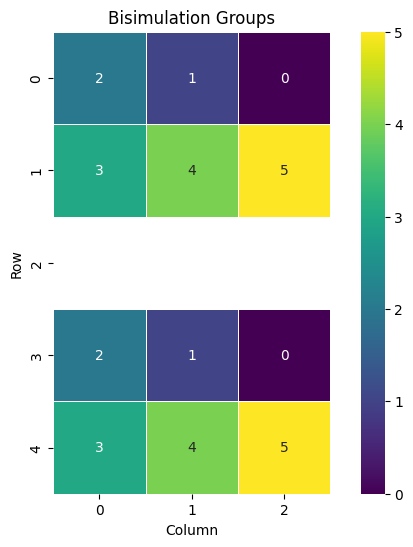

In [69]:
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import seaborn as sns

def plot_grid_with_groups(grid, groups, valid_states, title = 'Bisimulation Groups'):

    def get_group_idx(groups, state):
        for idx, (group, states) in enumerate(groups.items()):
            if state in states:
                return idx
        return -1

    # Create a grid with NaN values for invalid states
    heatmap = np.full(grid.shape, np.nan)

    # Fill the grid with the normalized distances
    for idx, (r, c) in enumerate(valid_states):
        heatmap[r, c] = get_group_idx(groups, (r, c))

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap, annot=True, cmap='viridis', cbar=True, square=True, linewidths=0.5)
    plt.title(title)
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.xticks(ticks=np.arange(3) + 0.5, labels=np.arange(3))
    plt.yticks(ticks=np.arange(5) + 0.5, labels=np.arange(5))
    plt.show()

plot_grid_with_groups(grid, groups, list(rewards.keys()))

In [70]:
# Define the grid world environment
file_path = 'custom_envs/grid_envs/grid_world1.txt'
grid = read_grid_world(file_path)
print(grid)

rewards, transitions = calculate_rewards_and_transitions(grid)

[['.' '.' 'G']
 ['.' '.' '.']
 ['x' '.' 'x']
 ['.' '.' 'G']
 ['.' '.' '.']]


In [71]:
# Hand made groups by considering that the previous groups have the same reward
# groups = {
#     f"c{i + 1}" : [state] for i, state in enumerate(list(rewards.keys()))
# }
groups = {
 'c1': [(0, 2)],
 'c2': [(0, 1)],
 'c3': [(0, 0)],
 'c4': [(1, 0)],
 'c5': [(1, 1)],
 'c6': [(1, 2)],
 'c7': [(2, 1)],
 'c8': [(3, 0)],
 'c9': [(3, 1)],
 'c10': [(3, 2)],
 'c11': [(4, 0)],
 'c12': [(4, 1)],
 'c13': [(4, 2)]}
groups

{'c1': [(0, 2)],
 'c2': [(0, 1)],
 'c3': [(0, 0)],
 'c4': [(1, 0)],
 'c5': [(1, 1)],
 'c6': [(1, 2)],
 'c7': [(2, 1)],
 'c8': [(3, 0)],
 'c9': [(3, 1)],
 'c10': [(3, 2)],
 'c11': [(4, 0)],
 'c12': [(4, 1)],
 'c13': [(4, 2)]}

In [72]:
_ = check_transition_equivalence(groups, transitions, grid)

Checking probs one hots by groups: 
c1: 
State (0, 2) to all groups:  [[1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
c2: 
State (0, 1) to all groups:  [[0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
c3: 
State (0, 0) to all groups:  [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
c

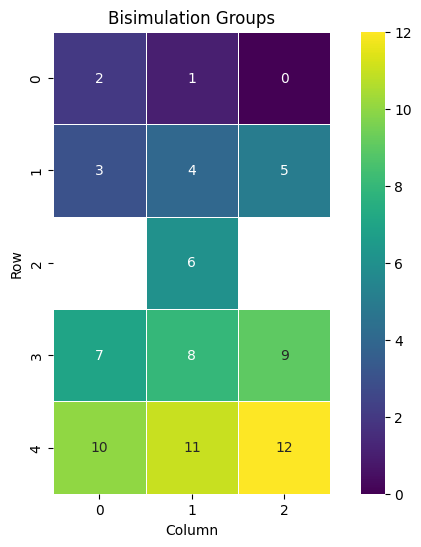

In [73]:
plot_grid_with_groups(grid, groups, list(rewards.keys()))

## On-Policy Bisimulaiton

In [74]:
import numpy as np

def value_iteration(grid, gamma=0.9, epsilon=1e-4):
    # Define parameters
    rows, cols = grid.shape
    gamma = 0.9
    # reward_goal = 10
    epsilon = 1e-4

    # Initialize value function
    V = np.zeros((rows, cols))

    # Define the transition probabilities and rewards
    def get_next_state(r, c, action):
        if action == 'up':
            return max(r - 1, 0), c
        elif action == 'down':
            return min(r + 1, rows - 1), c
        elif action == 'left':
            return r, max(c - 1, 0)
        elif action == 'right':
            return r, min(c + 1, cols - 1)
        
    def reward(r, c):
        if grid[r][c] == 'G':
            return REWARD_FUNC['G']
        else:
            return REWARD_FUNC['.']

    def is_terminal(r, c):
        return grid[r][c] == 'G' or grid[r][c] == 'x'

    # Value iteration
    while True:
        delta = 0
        new_V = np.copy(V)
        for r in range(rows):
            for c in range(cols):
                if not is_terminal(r, c):
                    max_value = float('-inf')
                    for action in ACTION_SPACE:
                        next_r, next_c = get_next_state(r, c, action)
                        if grid[next_r][next_c] != 'x':
                            value = reward(next_r, next_c) + gamma * V[next_r][next_c]
                            if value > max_value:
                                max_value = value
                    new_V[r][c] = max_value
                    delta = max(delta, abs(new_V[r][c] - V[r][c]))
        V = new_V
        if delta < epsilon:
            break

    # Extract policy
    policy = np.full((rows, cols), ' ')
    for r in range(rows):
        for c in range(cols):
            if not is_terminal(r, c):
                max_value = float('-inf')
                best_action = None
                for action in ACTION_SPACE:
                    next_r, next_c = get_next_state(r, c, action)
                    if grid[next_r][next_c] != 'x':
                        value = reward(next_r, next_c) + gamma * V[next_r][next_c]
                        if value > max_value:
                            max_value = value
                            best_action = action
                policy[r][c] = best_action[0]  # Just take the first letter of the action

    return V, policy

# Define the grid world environment
file_path = 'custom_envs/grid_envs/grid_world.txt'
grid = read_grid_world(file_path)
print(grid)

rewards, transitions = calculate_rewards_and_transitions(grid)

# Run value iteration
V, policy = value_iteration(grid)

# Display the results
print("Optimal Value Function:")
print(V)
print("\nOptimal Policy:")
print(policy)


[['.' '.' 'G']
 ['.' '.' '.']
 ['x' 'x' 'x']
 ['.' '.' 'G']
 ['.' '.' '.']]
Optimal Value Function:
[[ 8.  10.   0. ]
 [ 6.2  8.  10. ]
 [ 0.   0.   0. ]
 [ 8.  10.   0. ]
 [ 6.2  8.  10. ]]

Optimal Policy:
[['r' 'r' ' ']
 ['u' 'u' 'u']
 [' ' ' ' ' ']
 ['r' 'r' ' ']
 ['u' 'u' 'u']]


In [75]:
groups = group_by_reward_equivalente(rewards, policy)
# groups = replace_one_hot_key_with_group(groups)

groups

defaultdict(list,
            {-1: [(0, 0), (1, 0), (1, 1), (3, 0), (4, 0), (4, 1)],
             10: [(0, 1), (1, 2), (3, 1), (4, 2)],
             0: [(0, 2), (3, 2)]})

In [76]:
_ = check_transition_equivalence(groups, transitions, grid, policy)


Checking probs one hots by groups: 
c1: 
State (0, 0) to all groups:  [[0.0], [1.0], [0.0]]
State (1, 0) to all groups:  [[1.0], [0.0], [0.0]]
State (1, 1) to all groups:  [[0.0], [1.0], [0.0]]
State (3, 0) to all groups:  [[0.0], [1.0], [0.0]]
State (4, 0) to all groups:  [[1.0], [0.0], [0.0]]
State (4, 1) to all groups:  [[0.0], [1.0], [0.0]]
The transition probabilities are not the same for all the states in the group c1
c2: 
State (0, 1) to all groups:  [[0.0], [0.0], [1.0]]
State (1, 2) to all groups:  [[0.0], [0.0], [1.0]]
State (3, 1) to all groups:  [[0.0], [0.0], [1.0]]
State (4, 2) to all groups:  [[0.0], [0.0], [1.0]]
c3: 
State (0, 2) to all groups:  [[0.0], [0.0], [1.0]]
State (3, 2) to all groups:  [[0.0], [0.0], [1.0]]


In [77]:
# Hand mande groups
groups = {
    "c1" : [(0,2), (3,2)],
    "c2" : [(0, 1), (1, 2), (3, 1), (4, 2)],
    "c3" : [(0,0), (3,0), (1, 1), (4, 1)],
    "c4" : [(1,0), (4,0)],
}

In [78]:
_ = check_transition_equivalence(groups, transitions, grid, policy)


Checking probs one hots by groups: 
c1: 
State (0, 2) to all groups:  [[1.0], [0.0], [0.0], [0.0]]
State (3, 2) to all groups:  [[1.0], [0.0], [0.0], [0.0]]
c2: 
State (0, 1) to all groups:  [[1.0], [0.0], [0.0], [0.0]]
State (1, 2) to all groups:  [[1.0], [0.0], [0.0], [0.0]]
State (3, 1) to all groups:  [[1.0], [0.0], [0.0], [0.0]]
State (4, 2) to all groups:  [[1.0], [0.0], [0.0], [0.0]]
c3: 
State (0, 0) to all groups:  [[0.0], [1.0], [0.0], [0.0]]
State (3, 0) to all groups:  [[0.0], [1.0], [0.0], [0.0]]
State (1, 1) to all groups:  [[0.0], [1.0], [0.0], [0.0]]
State (4, 1) to all groups:  [[0.0], [1.0], [0.0], [0.0]]
c4: 
State (1, 0) to all groups:  [[0.0], [0.0], [1.0], [0.0]]
State (4, 0) to all groups:  [[0.0], [0.0], [1.0], [0.0]]


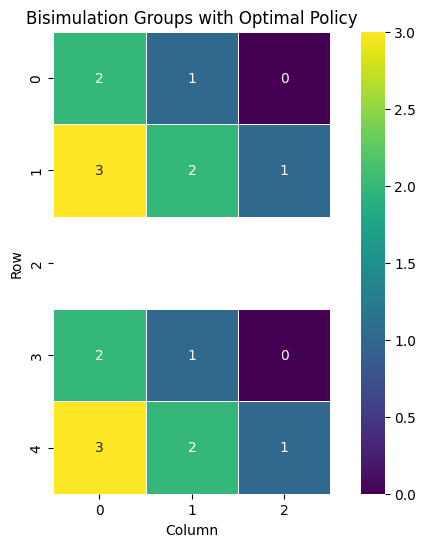

In [79]:
plot_grid_with_groups(grid, groups, list(rewards.keys()), title = 'Bisimulation Groups with Optimal Policy')

### Opening a passage

In [80]:
# Define the grid world environment
file_path = 'custom_envs/grid_envs/grid_world1.txt'
grid = read_grid_world(file_path)
print(grid)

rewards, transitions = calculate_rewards_and_transitions(grid)

# Run value iteration
V, policy = value_iteration(grid)

# Display the results
print("Optimal Value Function:")
print(V)
print("\nOptimal Policy:")
print(policy)

[['.' '.' 'G']
 ['.' '.' '.']
 ['x' '.' 'x']
 ['.' '.' 'G']
 ['.' '.' '.']]
Optimal Value Function:
[[ 8.  10.   0. ]
 [ 6.2  8.  10. ]
 [ 0.   8.   0. ]
 [ 8.  10.   0. ]
 [ 6.2  8.  10. ]]

Optimal Policy:
[['r' 'r' ' ']
 ['u' 'u' 'u']
 [' ' 'd' ' ']
 ['r' 'r' ' ']
 ['u' 'u' 'u']]


In [81]:
groups = group_by_reward_equivalente(rewards, policy)
# groups = replace_one_hot_key_with_group(groups)

groups

defaultdict(list,
            {-1: [(0, 0), (1, 0), (1, 1), (2, 1), (3, 0), (4, 0), (4, 1)],
             10: [(0, 1), (1, 2), (3, 1), (4, 2)],
             0: [(0, 2), (3, 2)]})

In [82]:
_ = check_transition_equivalence(groups, transitions, grid, policy)

Checking probs one hots by groups: 
c1: 
State (0, 0) to all groups:  [[0.0], [1.0], [0.0]]
State (1, 0) to all groups:  [[1.0], [0.0], [0.0]]
State (1, 1) to all groups:  [[0.0], [1.0], [0.0]]
State (2, 1) to all groups:  [[0.0], [1.0], [0.0]]
State (3, 0) to all groups:  [[0.0], [1.0], [0.0]]
State (4, 0) to all groups:  [[1.0], [0.0], [0.0]]
State (4, 1) to all groups:  [[0.0], [1.0], [0.0]]
The transition probabilities are not the same for all the states in the group c1
c2: 
State (0, 1) to all groups:  [[0.0], [0.0], [1.0]]
State (1, 2) to all groups:  [[0.0], [0.0], [1.0]]
State (3, 1) to all groups:  [[0.0], [0.0], [1.0]]
State (4, 2) to all groups:  [[0.0], [0.0], [1.0]]
c3: 
State (0, 2) to all groups:  [[0.0], [0.0], [1.0]]
State (3, 2) to all groups:  [[0.0], [0.0], [1.0]]


In [86]:
# Hand mande groups

groups = {
    "c1" : [(0,2), (3,2)],
    "c2" : [(0, 1), (1, 2), (3, 1), (4, 2)],
    "c3" : [(0,0), (3,0), (1, 1), (4, 1), (2, 1)],
    "c4" : [(1,0), (4,0)],
}

In [87]:
_ = check_transition_equivalence(groups, transitions, grid, policy)

Checking probs one hots by groups: 
c1: 
State (0, 2) to all groups:  [[1.0], [0.0], [0.0], [0.0]]
State (3, 2) to all groups:  [[1.0], [0.0], [0.0], [0.0]]
c2: 
State (0, 1) to all groups:  [[1.0], [0.0], [0.0], [0.0]]
State (1, 2) to all groups:  [[1.0], [0.0], [0.0], [0.0]]
State (3, 1) to all groups:  [[1.0], [0.0], [0.0], [0.0]]
State (4, 2) to all groups:  [[1.0], [0.0], [0.0], [0.0]]
c3: 
State (0, 0) to all groups:  [[0.0], [1.0], [0.0], [0.0]]
State (3, 0) to all groups:  [[0.0], [1.0], [0.0], [0.0]]
State (1, 1) to all groups:  [[0.0], [1.0], [0.0], [0.0]]
State (4, 1) to all groups:  [[0.0], [1.0], [0.0], [0.0]]
State (2, 1) to all groups:  [[0.0], [1.0], [0.0], [0.0]]
c4: 
State (1, 0) to all groups:  [[0.0], [0.0], [1.0], [0.0]]
State (4, 0) to all groups:  [[0.0], [0.0], [1.0], [0.0]]


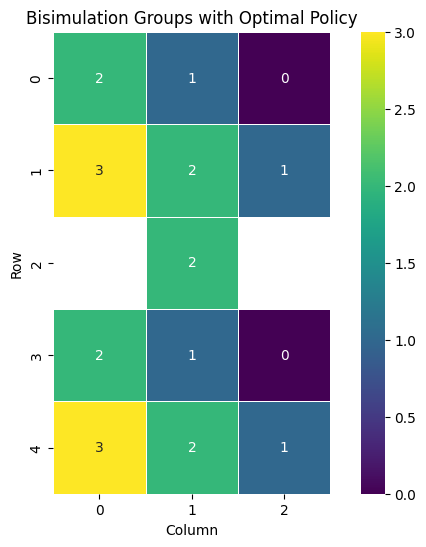

In [88]:
plot_grid_with_groups(grid, groups, list(rewards.keys()), title = 'Bisimulation Groups with Optimal Policy')